# Location and Timing of Crime in the city of Seattle

**Primary Findings:**
 
 - Criminal activity is highest in Seattle between midnight and 1AM.
 - Criminal activity is focused in the Greater CBD areas, namely Broadway, Belltown and Central Business District.
 - Crime density is focused in the greater CBD areas day and night.  However, at night, crime density shifts Northwards into the Broadway and Belltown areas, possible due to increased nightlife.

<hr>
<div style="padding-left:20px">
*Jake Bouma*<br>
<a>jake.t.bouma@gmail.com</a>
<p>November 2015
</div>
<hr>

## (0) The Seattle crime dataset
The dataset contains summary data of 32779 crime incident reports during the period of summer 2014.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
dcrime = pd.read_csv('seattle_incidents_summer_2014.csv')
dcrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32779 entries, 0 to 32778
Data columns (total 19 columns):
RMS CDW ID                           32779 non-null int64
General Offense Number               32779 non-null int64
Offense Code                         32779 non-null object
Offense Code Extension               32779 non-null int64
Offense Type                         32779 non-null object
Summary Offense Code                 32779 non-null object
Summarized Offense Description       32779 non-null object
Date Reported                        32779 non-null object
Occurred Date or Date Range Start    32779 non-null object
Occurred Date Range End              16499 non-null object
Hundred Block Location               32779 non-null object
District/Sector                      32722 non-null object
Zone/Beat                            32723 non-null object
Census Tract 2000                    32645 non-null float64
Longitude                            32779 non-null float64
Latitud

/opt/conda/envs/python2/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## (1) When do the crimes occur? 
The goal is to visualize at what hour of the day the most crimes occur by binning the number of incidents by hour and plotting the resulting histogram.

day      16513
night    16266
dtype: int64


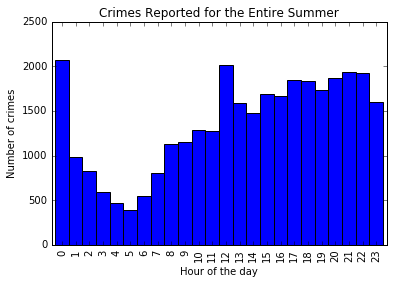

In [2]:
times = pd.datetools.to_datetime(dcrime['Occurred Date or Date Range Start'])
hours = times.apply(lambda x: x.hour)
def day_or_night(hour):
    if 6 <= hour < 18:
        return 'day'
    else:
        return 'night'
dcrime['daynight'] = hours.apply(day_or_night)
print dcrime['daynight'].value_counts()
hours.value_counts(sort=False).plot(kind='bar', width=1)
plt.title('Crimes Reported for the Entire Summer');
plt.xlabel('Hour of the day');
plt.ylabel('Number of crimes');

**Finding:** *Criminal activity is highest in Seattle between midnight and 1AM*
>There is a steady increase in crime throughout the course of the day, starting from a minimum at 5AM through to a maximum at midnight.  The spike in crimes at 12:00 noon is likely due to either a default value captured by police or the victim being more likely to report uncertain times as "around noon".


## (2) Where do the crimes occur?
The goal is to highlight crime hotspots in Seattle.  A basemap of neighbourhoods in Seattle with a colour-scale indicating the number of crimes will emphasize the location information at the expense of clarity in the crime frequency.

In [3]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [4]:
#Get the Shapefile for Seattle here;
#!wget https://data.seattle.gov/download/2mbt-aqqx/application/zip

### Build up basemap & geometries

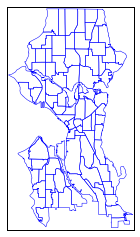

In [5]:
# Open up the shapefile to find the coordinate bounds for the basemap
shapefilename = './Neighborhoods/WGS84/Neighborhoods'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
shp.close()
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

# Basemap of Seattle
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=pd.np.mean([coords[0], coords[2]]),
    lat_0=pd.np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

# Read in the shapefile that contains the neighbourhood divisions
m.readshapefile(shapefilename, name='seattle', drawbounds=True, color='Blue', zorder=2)
dgeo = pd.DataFrame(m.seattle_info)

In [6]:
# make a polygon for each neighbourhood
dgeo['poly'] = pd.Series([Polygon(hood_points) for hood_points in m.seattle])
hood_polygons = prep(MultiPolygon(list(dgeo['poly'].values)))

# make a point for each crime (mapped into the basemap's coordinate system)
dcrime['point'] = [
    Point(m(mapped_x, mapped_y))\
    for mapped_x, mapped_y \
    in zip(dcrime.Longitude, dcrime.Latitude)
]

### Crimes outside of Seattle bounds
There are about 2137 reported crimes that are outside of the bounds of the Seattle map.  The distributions of these points (Offense Types) looks much the same as the other points, so it is acceptable to leave these points out of the neighbourhood visualization.

In [7]:
# check for points outside of the city bounds
dcrime['point_in_map'] = dcrime['point'].apply(hood_polygons.contains)
dcrime.loc[~dcrime['point_in_map'], ['Offense Type', 'Summarized Offense Description', 'Zone/Beat']]

,Offense Type,Summarized Offense Description,Zone/Beat
93,PROPERTY LOST,LOST PROPERTY,99
127,NARC-SELL-HEROIN,NARCOTICS,99
486,THEFT-LICENSE PLATE,OTHER PROPERTY,C3
494,PROPERTY DAMAGE - GRAFFITI,PROPERTY DAMAGE,B3
510,THEFT-LICENSE PLATE,OTHER PROPERTY,Q1
512,PROPERTY DAMAGE-RESIDENTIAL,PROPERTY DAMAGE,S3
518,THEFT-MAIL,MAIL THEFT,B1
519,VIOL-COURT ORDER,VIOLATION OF COURT ORDER,D2
522,THEFT-SHOPLIFT,SHOPLIFTING,N3
524,THEFT-SHOPLIFT,SHOPLIFTING,N3


### Bin crimes into neighbourhoods
Make a distinction between day and night to investigate the difference in crime hotspots between day and night.

In [8]:
bvec_daypoints = (dcrime.daynight=='day') & (dcrime.point_in_map)
dgeo['ncrimes_day'] = dgeo.poly.apply(
    lambda poly: len(filter(poly.contains, dcrime.loc[bvec_daypoints, 'point'].values))
)
bvec_nightpoints = (dcrime.daynight=='night') & (dcrime.point_in_map)
dgeo['ncrimes_night'] = dgeo.poly.apply(
    lambda poly: len(filter(poly.contains, dcrime.loc[bvec_nightpoints, 'point'].values))
)
dgeo['ncrimes'] = dgeo['ncrimes_night'] + dgeo['ncrimes_day']

In [48]:
# colour map
cmap=plt.cm.hot
def normalize_freq(v, value_field):
    upper = float(dgeo[value_field].max())
    lower = float(dgeo[value_field].min())
    return 1.0 - pd.np.sqrt((v-lower) / (upper - lower))

# colour and plot patches onto given axis
def plot_patches(row, ax, value_field):
    col = cmap(normalize_freq(row[value_field], value_field))
    p = PolygonPatch(row.poly, facecolor=col, label='x', ec='#111111', lw=.8, alpha=1., zorder=4)
    ax.add_patch(p)
    return p

# colour and plot labels onto given axis
def plot_patch_labels(row, ax, label_field, value_field):
    col = cmap(1 - normalize_freq(row[value_field], value_field))
    ax.text(row.poly.centroid.x, row.poly.centroid.y, row[label_field],
             zorder=5, horizontalalignment='center', 
             verticalalignment='center', fontsize=10, color=col)

### Finally, plot the maps

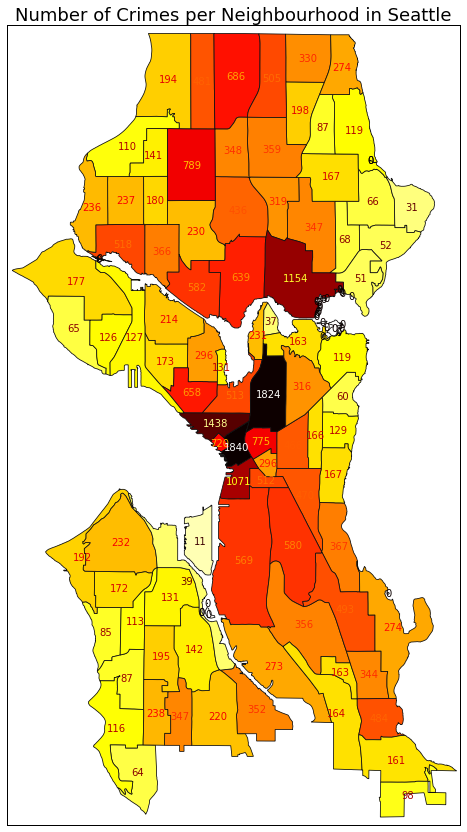

In [71]:
# draw the figure
figwidth = 12
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
dgeo.apply(plot_patches, axis=1, args=[ax, 'ncrimes']);
m.drawmapboundary();
dgeo.apply(plot_patch_labels, axis=1, args=[ax,'ncrimes','ncrimes']);
plt.title('Number of Crimes per Neighbourhood in Seattle', fontsize=18);

Both the colour scale and the number label indicates the number of crimes per neighbourhood.

**Finding:** *Most crimes occur in the Central Business District.*

In [76]:
# Show the neighbourhoods with the most crimes
dgeo.loc[dgeo.S_HOOD!='OOO', ['S_HOOD','ncrimes']].sort('ncrimes', ascending=False).head(10)

,S_HOOD,ncrimes
61,Central Business District,1840
99,Broadway,1824
59,Belltown,1438
41,University District,1154
64,Pioneer Square,1071
119,Greenwood,789
62,First Hill,775
58,Pike-Market,720
113,Haller Lake,686
44,Lower Queen Anne,658


### Normalize by Neighbourhood area
The above view doesn't consider the size of each neighbourhood.  A slightly better way to visualize crime density is to normalize each neighbourhood count by the area of the neighbourhood.

In [90]:
dgeo['ncrimes_normed'] = dgeo['ncrimes'] / dgeo['AREA']

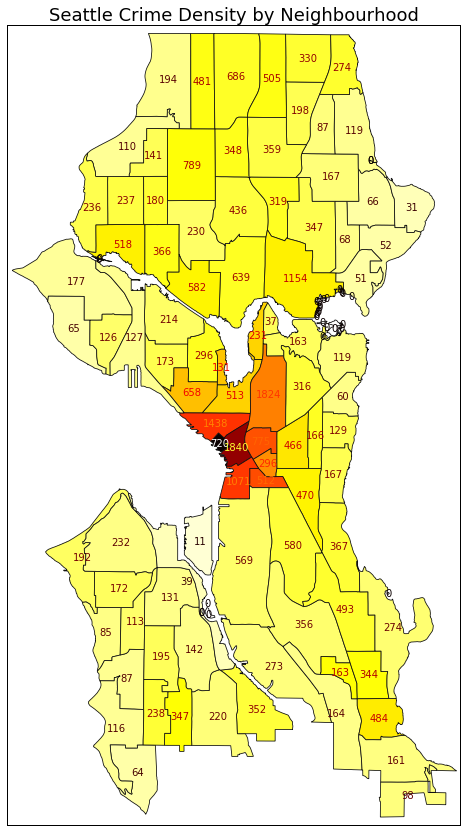

In [91]:
# draw the figure
figwidth = 12
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
dgeo.apply(plot_patches, axis=1, args=[ax, 'ncrimes_normed']);
m.drawmapboundary();
dgeo.apply(plot_patch_labels, axis=1, args=[ax,'ncrimes','ncrimes_normed']);
plt.title('Seattle Crime Density by Neighbourhood', fontsize=18);

**Finding:** *The highest crime density is in the Pike-Market Area.*
> Crime density shows a slightly different picture in the high crime area.  The smaller Pike-Market area has a much greater crime density than the much larger CBD area.

## (3) Do crimes

### DAY

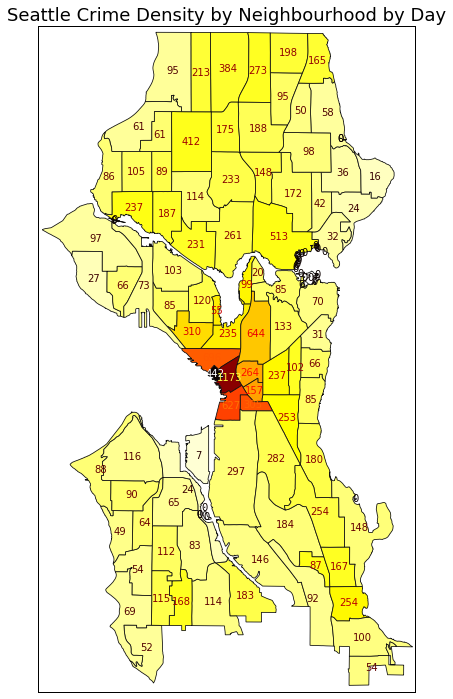

In [95]:
dgeo['ncrimes_day_normed'] = dgeo['ncrimes_day'] / dgeo['AREA']
# draw the figure
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
dgeo.apply(plot_patches, axis=1, args=[ax, 'ncrimes_day_normed']);
m.drawmapboundary();
dgeo.apply(plot_patch_labels, axis=1, args=[ax,'ncrimes_day','ncrimes_day_normed']);
plt.title('Seattle Crime Density by Neighbourhood by Day', fontsize=18);

In [96]:
# Show the neighbourhoods with the most crimes in the day
dgeo.loc[dgeo.S_HOOD!='OOO', ['S_HOOD','ncrimes_day']].sort('ncrimes_day', ascending=False).head(10)

,S_HOOD,ncrimes_day
61,Central Business District,1173
59,Belltown,696
99,Broadway,644
64,Pioneer Square,627
41,University District,513
58,Pike-Market,442
119,Greenwood,412
113,Haller Lake,384
44,Lower Queen Anne,310
60,International District,305


### NIGHT

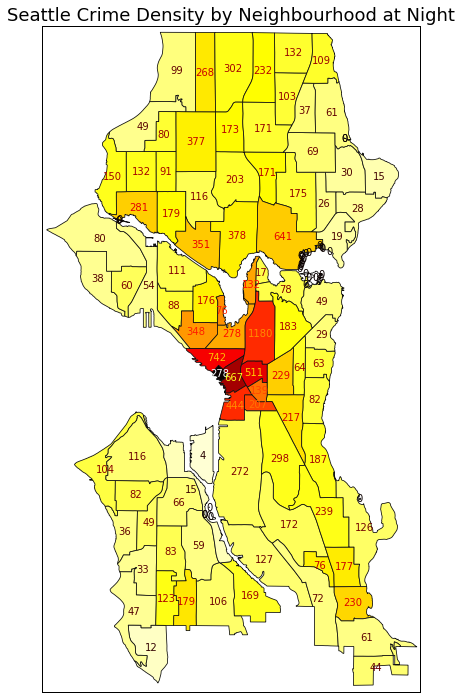

In [94]:
dgeo['ncrimes_night_normed'] = dgeo['ncrimes_night'] / dgeo['AREA']
# draw the figure
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
dgeo.apply(plot_patches, axis=1, args=[ax, 'ncrimes_night_normed']);
m.drawmapboundary();
dgeo.apply(plot_patch_labels, axis=1, args=[ax,'ncrimes_night','ncrimes_night_normed']);
plt.title('Seattle Crime Density by Neighbourhood at Night', fontsize=18);

In [98]:
# Show the neighbourhoods with the most crimes in the night
dgeo.loc[dgeo.S_HOOD!='OOO', ['S_HOOD','ncrimes_night']].sort('ncrimes_night', ascending=False).head(10)

,S_HOOD,ncrimes_night
99,Broadway,1180
59,Belltown,742
61,Central Business District,667
41,University District,641
62,First Hill,511
64,Pioneer Square,444
31,Wallingford,378
119,Greenwood,377
32,Fremont,351
44,Lower Queen Anne,348


**Finding:** *Although the **greater** CBD area has the most crime both day night, the detailed distribution changes at night, with focus shifting northwards out from the CBD towards the Belltown and Broadway areas.*
> This could be due to increased nightlife in these areas compared to the night life in the CBD.  I would expect to see a greater proportion of people out and about in the Northern CBD areas compared to the Southern CBD areas at night than during the day.